# 1. Introdução

Nosso trabalho aqui consiste em criar um modelo para prever preços de diamantes a partir de suas características.

Fonte: https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices

# 2. Importando bibliotecas

In [1]:
# Para tratar os dados
import pandas as pd
import numpy as np

# Pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer # pipeline com colunas de tipos diferentes
from sklearn.impute import SimpleImputer # missing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder # escala das features / tratar categóricas numéricas
from category_encoders import TargetEncoder, OneHotEncoder # tratamento de categóricas
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_regression # selecao de features

# Modelagem
import lightgbm as lgb


### Importando o Dataset

In [2]:
diamonds_data = pd.read_csv('Diamonds Prices2022.csv')

In [3]:
diamonds_data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
diamonds_data.shape

(53943, 11)

In [5]:
diamonds_data.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000
mean,26972.000000,0.797935,61.749322,57.457251,3932.734294,5.731158,5.734526,3.538730
std,15572.147122,0.473999,1.432626,2.234549,3989.338447,1.121730,1.142103,0.705679
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13486.500000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26972.000000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40457.500000,1.040000,62.500000,59.000000,5324.000000,6.540000,6.540000,4.040000
max,53943.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [6]:
diamonds_data.isna().sum() # mean para ver a taxa de missing

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

Digamos que a gente queira excluir linhas com mais de 30% de missing. O que fazer?
```python
diamonds_data = (diamonds_data.isna().mean() <= 0.3).index
```

# 3. Análise Exploratória

Dessa vez, não vamos fazer análise exploratória. Vamos olhar mais sob a perspectiva de um projeto automatizado onde não é possível ficar olhando as features uma a uma. Além disso, nem sempre vamos conseguir confiar 100% na EDA. Então é importante conhecer técnicas de feature selection e não achar que a EDA é a resposta final.

# 4. Modelo preditivo de preço

In [7]:
diamonds_data.columns

Index(['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table',
       'price', 'x', 'y', 'z'],
      dtype='object')

In [8]:
# Vamos começar removendo a 'Unnamed: 0' que não vai nos servir de nada.
diamonds_data.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
diamonds_data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


A descrição no Kaggle nos informou que as variáveis cut, color e clarity são categóricas ordinais. Então a ordem delas importa.

In [10]:
diamonds_data['cut'].value_counts()

cut
Ideal        21551
Premium      13793
Very Good    12083
Good          4906
Fair          1610
Name: count, dtype: int64

 Fair ➡ Good ➡ Very Good ➡ Premium ➡ Ideal (Do pior para o melhor)

In [11]:
diamonds_data['color'].value_counts()

color
G    11292
E     9799
F     9543
H     8304
D     6775
I     5422
J     2808
Name: count, dtype: int64

J ➡ I ➡ H ➡ G ➡ F ➡ E ➡ D (Do pior para o melhor)

In [12]:
diamonds_data['clarity'].value_counts()

clarity
SI1     13067
VS2     12259
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: count, dtype: int64

 I1 ➡ SI2 ➡ SI1 ➡ VS2 ➡ VS1 ➡ VVS2 ➡ VVS1 ➡ IF (Do pior para o melhor)

Removendo duplicatas

In [13]:
diamonds_data[diamonds_data.duplicated()]

,carat,cut,color,clarity,depth,table,price,x,y,z
1005,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1006,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1007,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1008,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
2025,1.52,Good,E,I1,57.3,58.0,3105,7.53,7.42,4.28
...,...,...,...,...,...,...,...,...,...,...
50079,0.51,Ideal,F,VVS2,61.2,56.0,2203,5.19,5.17,3.17
52861,0.50,Fair,E,VS2,79.0,73.0,2579,5.21,5.18,4.09
53940,0.71,Premium,E,SI1,60.5,55.0,2756,5.79,5.74,3.49
53941,0.71,Premium,F,SI1,59.8,62.0,2756,5.74,5.73,3.43


In [14]:
diamonds_data.drop_duplicates(inplace=True)

Agora vamos verificar a presença de outliers. No caso de diamantes, é esperado que tenhamos uma variação considerável nos preços. Então vamos ver qual a porcentagem de outliers em cada coluna. Se a quantidade for pequena, podemos considerar que podem ser dados legítimos e/ou o impacto no modelo não deve ser significativo.

In [15]:
# Verificando quais são as colunas numéricas. Vamos aproveitar pra criar a lista de categóricas também.

numerical_columns = diamonds_data.select_dtypes(include="number").columns.to_list()
categorical_columns = diamonds_data.select_dtypes(exclude="number").columns.to_list()

In [16]:
numerical_columns

['carat', 'depth', 'table', 'price', 'x', 'y', 'z']

In [17]:
categorical_columns

['cut', 'color', 'clarity']

Caso fosse necessário, uma forma de criar dataframes de features numéricas e categóricas seria:
```python
cols = diamonds_data.dtypes.reset_index().rename(columns={'index': 'coluna', 0: 'tipo'})
num_cols = cols[cols['tipo'] != object]
categ_cols = cols[cols['tipo'] == object]
```
Dessa forma teríamos um dataframe com as colunas e seus tipos (int, float, object, etc.).

In [18]:
# Detectando outliers

nomes_colunas = []
qtt_outliers = []

for i in numerical_columns:
    
    contador = 0
    
    q1 = np.quantile(diamonds_data[i], 0.25) # primeiro quartil
    q3 = np.quantile(diamonds_data[i], 0.75) # terceiro quartil
    li = q1 - 1.5*(q3-q1) # limite inferior
    ls = q3 + 1.5*(q3-q1) # limite superior
    
    for j in diamonds_data.index:
        if li <= diamonds_data[i][j] <= ls:
            pass
        else:
            contador += 1
    
    perc_outliers = (contador / diamonds_data[i].count())*100 # porcentagem da quantidade de outliers nessa coluna
    
    nomes_colunas.append(i)
    qtt_outliers.append(perc_outliers)

In [19]:
nomes_colunas

['carat', 'depth', 'table', 'price', 'x', 'y', 'z']

In [20]:
outliers = pd.DataFrame()
outliers['coluna'] = nomes_colunas
outliers['perc_outliers'] = qtt_outliers
outliers

,coluna,perc_outliers
0,carat,3.481801
1,depth,4.693832
2,table,1.122802
3,price,6.549058
4,x,0.057627
5,y,0.052050
6,z,0.089229


Se eu quisesse filtrar as colunas com mais de X% de outliers, por exemplo, poderia fazer assim:
```python
outliers[outliers['perc_outliers'] > X]
```

Como pudemos visualizar, a quantidade de outliers é bem pequena. A coluna Price é a que tem a maior quantidade de outliers com 6,5%. Então, nesse caso, não vamos optar pela remoção desses outliers.

Agora vamos remover a coluna price da nossa lista de colunas numéricas, afinal, ele é o nosso target.

In [21]:
numerical_columns = [feature for feature in numerical_columns if feature != 'price']
numerical_columns

['carat', 'depth', 'table', 'x', 'y', 'z']

In [22]:
target = 'price'

Antes de fazer a divisão, vamos fazer um mapeamento nas colunas categóricas. Como foi dito anteriormente, a ordem delas importa, então vamos fazer um Ordinal Encoder manualmente. O ideal é sempre fazer o pré-processamento após o split, porém, como nesse caso não estamos usando informações da coluna inteira para preencher um missing, por exemplo, não teremos risco de data leakage. Portanto, podemos fazer esse encoding antes da divisão (e nesse caso, é até mais prático).

In [23]:
diamonds_data['cut'] = diamonds_data['cut'].map({'Fair':0, 'Good':1, 'Very Good':2, 'Premium':3, 'Ideal':4})
diamonds_data['color'] = diamonds_data['color'].map({'J':0, 'I':1, 'H':2, 'G':3, 'F':4, 'E':5, 'D':6})
diamonds_data['clarity'] = diamonds_data['clarity'].map({'I1':0, 'SI2':1, 'SI1':2, 'VS2':3, 'VS1':4, 'VVS2':5, 'VVS1':6, 'IF':7})

In [24]:
X = diamonds_data[numerical_columns + categorical_columns]
y = diamonds_data[target]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (37655, 9)
X_test shape: (16139, 9)
y_train shape: (37655,)
y_test shape: (16139,)


In [26]:
lgb_model = lgb.LGBMRegressor()

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

# Obs.: Nesse nosso caso, as colunas categóricas já foram transformadas em numéricas. Vamos manter o nome
# assim por uma questão de organização, mas na prática o nosso categorical_transformer vai funcionar assim
# como o numerical_transformer.
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_columns),
    ('cat', categorical_transformer, categorical_columns)
]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k='all')), 
    ('model', lgb_model)
])

# Treina o modelo
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('feature_selection',
                 SelectKBest(k='all',
                             score_func=<function f_regression at 0x000001DEF995AE50>)),
                ('model', LGBMRegressor())])

Vamos enfim realizar a nossa predição e verificar o desempenho do modelo com algumas métricas.

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE) test:  {mse:.4f}')
print(f'Root Mean Squared Error (RMSE) test:  {rmse:.4f}')
print(f'Mean Absolute Error (MAE) test:  {mae:.4f}')
print(f'R-squared (R2) test:  {r2:.4f}')

Mean Squared Error (MSE) test:  265387.1684
Root Mean Squared Error (RMSE) test:  515.1574
Mean Absolute Error (MAE) test:  272.2429
R-squared (R2) test:  0.9827


Vamos comparar as mesmas métricas do modelo fazendo predições com os dados de treino agora.

In [28]:
y_pred_train = pipeline.predict(X_train)
mse = mean_squared_error(y_train, y_pred_train)
mae = mean_absolute_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred_train)

print(f'Mean Squared Error (MSE) train:  {mse:.4f}')
print(f'Root Mean Squared Error (RMSE) train:  {rmse:.4f}')
print(f'Mean Absolute Error (MAE) train:  {mae:.4f}')
print(f'R-squared (R2) train:  {r2:.4f}')

Mean Squared Error (MSE) train:  225619.6533
Root Mean Squared Error (RMSE) train:  474.9944
Mean Absolute Error (MAE) train:  260.3635
R-squared (R2) train:  0.9860


Agora uma comparação direta de 50 valores que o algoritmo preveu com os dados de teste.

In [29]:
y_test_list = y_test.to_list()
for x in range(0, 50):
    print(f'y_test: {y_test_list[x]} / y_pred: {y_pred[x]}')

y_test: 1435 / y_pred: 1760.9046473564624
y_test: 3584 / y_pred: 3546.8769114715024
y_test: 1851 / y_pred: 1815.719755627432
y_test: 1590 / y_pred: 1700.3466191810808
y_test: 5690 / y_pred: 5383.998300910552
y_test: 596 / y_pred: 670.3945690180915
y_test: 492 / y_pred: 593.7796964005291
y_test: 2063 / y_pred: 2123.193116074252
y_test: 970 / y_pred: 1069.239111773673
y_test: 4796 / y_pred: 4659.998616714996
y_test: 2476 / y_pred: 2723.825881566893
y_test: 8579 / y_pred: 8500.284003187602
y_test: 5000 / y_pred: 5246.083918983123
y_test: 1197 / y_pred: 1188.8909781287305
y_test: 10888 / y_pred: 10789.62639590212
y_test: 14766 / y_pred: 13936.732171953601
y_test: 3535 / y_pred: 3509.621685172072
y_test: 7416 / y_pred: 8101.375462507079
y_test: 4900 / y_pred: 4377.4767934777765
y_test: 974 / y_pred: 1025.3258823845258
y_test: 3528 / y_pred: 3500.476410921339
y_test: 3897 / y_pred: 5541.979841431135
y_test: 3920 / y_pred: 5105.509703408451
y_test: 3016 / y_pred: 3444.3379685850955
y_test: 68

Visualizando graficamente a comparação de y_test e y_pred

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

C:\Users\andre\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


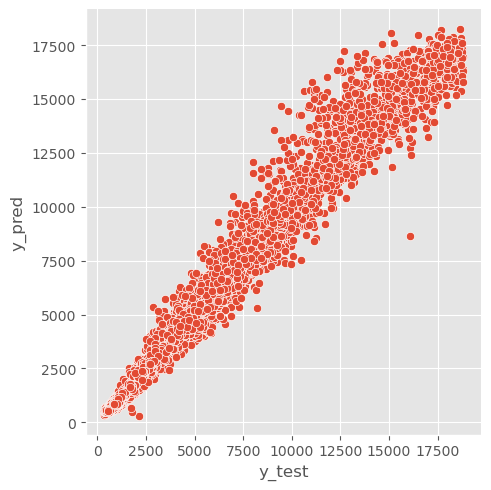

In [31]:
# Criar um DataFrame com y_test e y_pred
df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

# Plotar a relação entre as duas colunas
sns.relplot(data=df, x='y_test', y='y_pred')
plt.show()